In [1]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import pandas as pd
import os
os.sys.path.extend(['../evaluation'])
from evaluate import model_preprocessed_filepath
import glob
from matplotlib import pyplot as plt
import math
%matplotlib inline

chencherry = SmoothingFunction().method1

In [45]:
def get_scores(filepath, subset='all-cat'):
    
    references_files = [f'../evaluation/references/{subset}_reference{i}.lex' for i in range(3)]
    hypothesis_file = filepath

    scores = []
    hypothesis = []
    references = []

    with open(references_files[0], 'r', encoding='utf-8') as ref0,\
         open(references_files[1], 'r', encoding='utf-8') as ref1,\
         open(references_files[2], 'r', encoding='utf-8') as ref2,\
         open(hypothesis_file, 'r', encoding='utf-8') as hyp:


        for h, r0, r1, r2 in zip(hyp, ref0, ref1, ref2):

            references.append((r0[:-1], r1[:-1], r2[:-1]))
            hypothesis.append(h[:-1])

    for hyp, refs in zip(hypothesis, references):

        score = sentence_bleu([r.split() for r in refs], 
                              hyp.split(), 
                              smoothing_function=chencherry)

        scores.append(score)
        
    return scores, hypothesis, references
    

def plot_hist_bleu(filepath, ax, subset='all-cat'):

    scores, _, _ = get_scores(filepath, subset)
    
    s = pd.Series(scores)
    
    s.hist(ax=ax, bins=40)

In [46]:
def plot_all_models_hist_bleu(subset):
    
    models = [os.path.basename(s) for s in glob.glob('../data/models/*')]

    n_models = len(models)
    n_columns = 3
    n_rows = math.ceil(n_models / 3)

    fig, axes = plt.subplots(n_rows, n_columns, figsize=(15, 5*n_rows), sharey=True, sharex=True)

    for model, ax in zip(models, axes.ravel()):

        filepath = model_preprocessed_filepath(model, subset)

        plot_hist_bleu(filepath, ax, subset)
        ax.set_title(model)

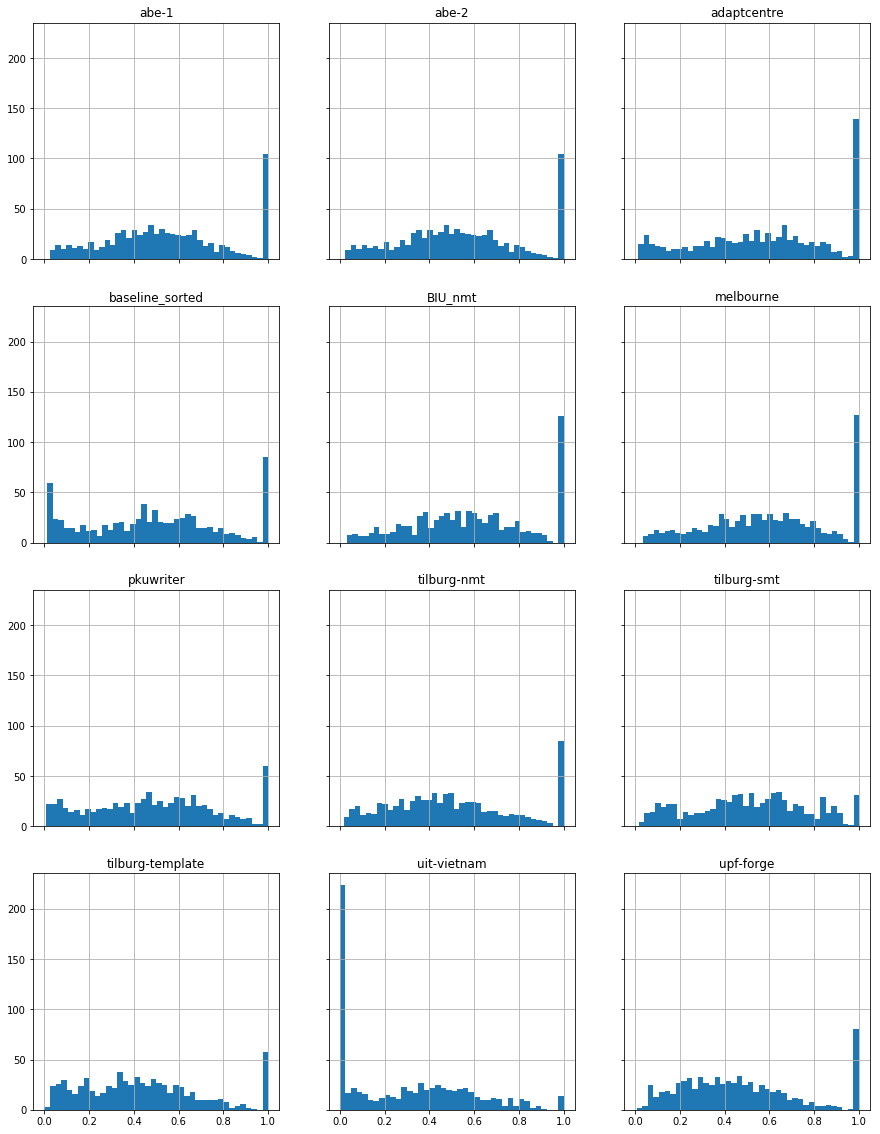

In [47]:
plot_all_models_hist_bleu('with-template')

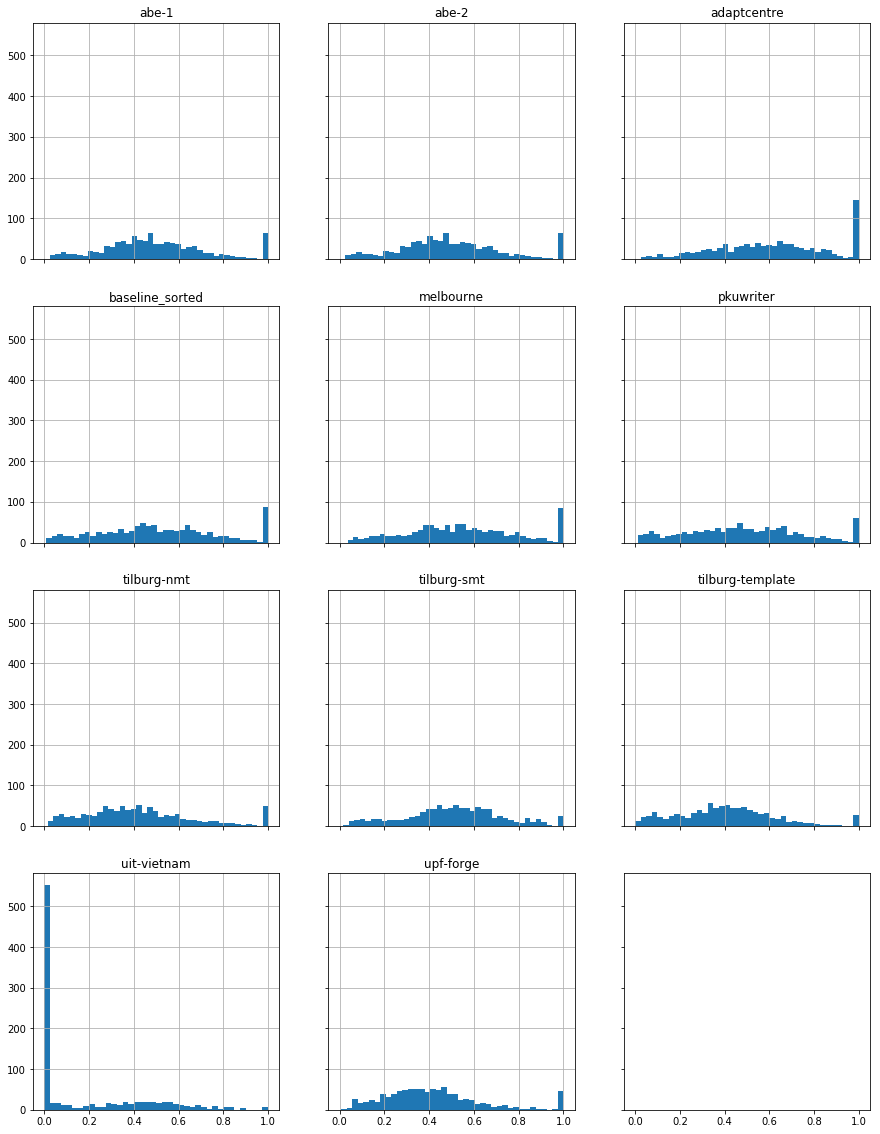

In [61]:
plot_all_models_hist_bleu('old-cat')

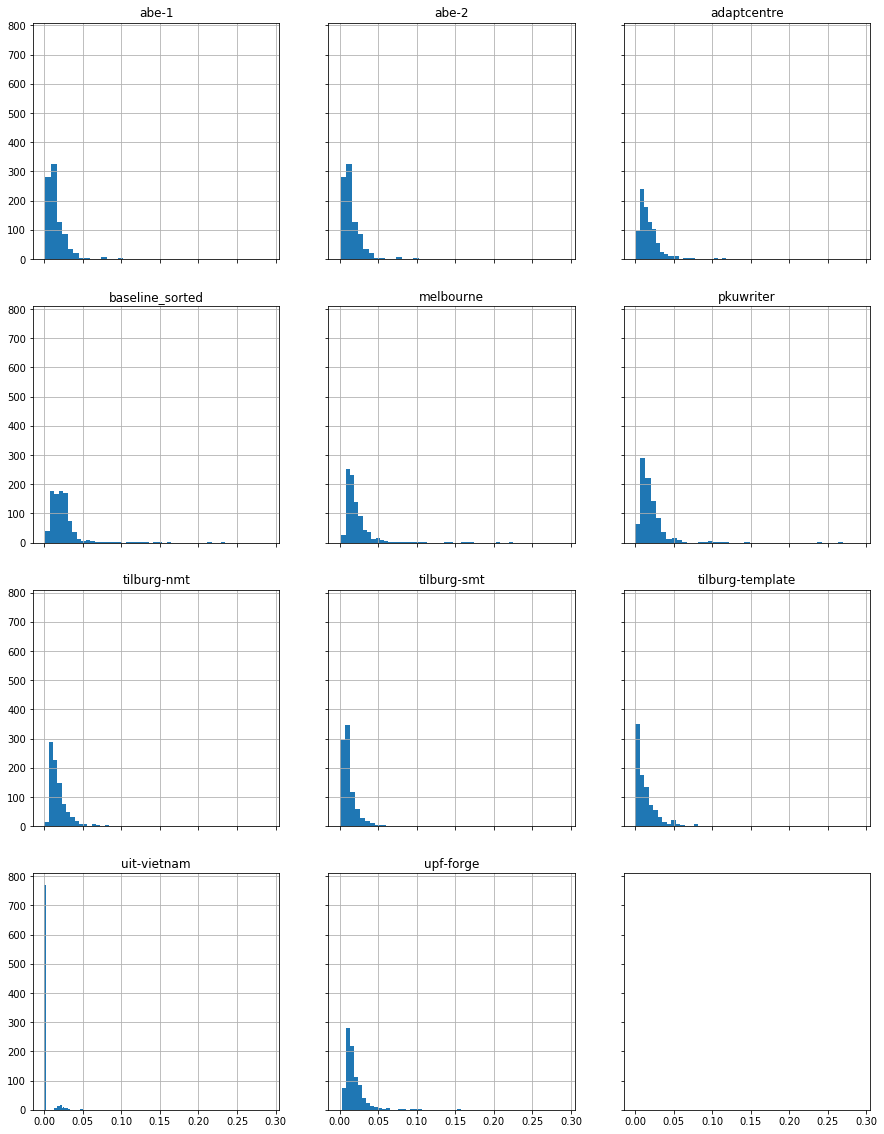

In [62]:
plot_all_models_hist_bleu('new-cat')

# Menores scores

In [41]:
scores, hypothesis, references = get_scores(model_preprocessed_filepath('abe-1', 'with-template'), 'with-template')
sorted_scores = sorted([(i, s) for i, s in enumerate(scores)], key=lambda v: v[1])

In [42]:
sorted_scores[120:130]

[(426, 0.2719326877457978),
 (338, 0.27206959652131624),
 (601, 0.27230882942629814),
 (429, 0.27278200342554276),
 (189, 0.274941620352113),
 (576, 0.28036745141301356),
 (507, 0.2816497457616417),
 (660, 0.28574404296988),
 (524, 0.2882083988168949),
 (614, 0.2893917519440823)]

In [43]:
hypothesis[426]

'bacon explosion comes from the united states , whose capital is washington dc and one of whose leaders is john roberts .'

In [44]:
references[426]

('bacon explosion originates in the united states , where john roberts is a leader and the capital is washington dc .',
 '',
 '')

In [39]:
sentence_bleu([r.split() for r in references[429]], 
              hypothesis[357].split(), 
              smoothing_function=chencherry)

0.1345311715522899

In [81]:
s = 'the largest city in tarrant county in texas is fort worth . austin , texas is the capital of . arlington is part of tarrant county in . is part of texas . is in the united states .'
sentence_bleu([r.split() for r in references[810]], 
              s.split(), 
              smoothing_function=chencherry)

0.28102440992536304